<a href="https://colab.research.google.com/github/lanyu0322/pedestrian_firstdraft_figures/blob/master/figure2_3pop_4pop_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from scipy.ndimage.filters import uniform_filter as uf

# -- install geopandas
try:
  import geopandas as gp
except:
  !pip install geopandas

     |████████████████████████████████| 931kB 3.4MB/s 
     |████████████████████████████████| 14.7MB 301kB/s 
     |████████████████████████████████| 10.9MB 20.7MB/s 


In [ ]:
# -- read in the weekday counts
camera_fname = os.path.join("drive", "My Drive", "lwir", "data", "nycdot", 
                            "cams_ft_wd.feather")
camera = pd.read_feather(camera_fname)

# -- read in the average weekend counts
fname = os.path.join("drive", "My Drive", "lwir", "data", "nycdot", 
                     "avg_weekend_ts.feather")
weekend = uf(pd.read_feather(fname)["avg_counts"].values, 8)

# -- extract just the counts from weekdays
camarr = camera.drop(columns=["cam_id", "lat", "lon"]).values

In [ ]:
# # -- standardized data
# camarr_m = camarr.mean(axis=1, keepdims=True)
# camarr_std = camarr.std(axis=1, keepdims=True)
# camarr_st = (camarr - camarr_m) / (camarr_std + (camarr_std == 0))



In [ ]:
# -- define gaussian
def gauss(xarr, x0, sig, scl):
  """ Create a 1D Gaussian """
  
  amp = scl / (sig * np.sqrt(2.0 * np.pi))
  val = -0.5 * ((xarr - x0) / sig)**2
  
  return amp * np.exp(val)


# -- define the model
def pop_model(param, xval):

  # -- determine which model is being used from length of param array
  nparam = len(param)

  # -- 3 population model
  if nparam == 10:
    m1, m2, m3, sd1, sd2, sd3, scl1, scl2, scl3, off = param
    wamp = 0.0

  # -- 4 population model
  elif nparam == 11:
    m1, m2, m3, sd1, sd2, sd3, scl1, scl2, scl3, wamp, off = param

  # -- ill-defined param array
  else:
    print("Nparam must be 10 (3pop) or 11 (4pop) model!")
    return None

  model = gauss(xval, m1, sd1, scl1) + gauss(xval, m2, sd2, scl2) + \
    gauss(xval, m3, sd3, scl3) + wamp * wendvals + off

  return model


# -- define model error
def res(param, xval, yval):

  return yval - pop_model(param, xval)

# fit 4-pop model

In [ ]:
#4-population fit for average weekday counts for all cameras

# -- set inital guess
avgs  = [35, 47, 70] 
sigs  = [3, 3, 3]
scls  = [5, 5, 5]
off   = [0.5]
wamp = [6]
param = avgs + sigs + scls + wamp + off

# -- set fit and model parameters and 
wendvals = weekend
xval_final = np.arange(96)
bounds_lo = [24., 44., 64., 2.0, 2.0, 2.0, 0, 0, 0, 0, -np.inf]
bounds_hi = [44., 64., 80., 8., 8., 8., np.inf, np.inf, np.inf, np.inf, np.inf]

# -- optimize
plsq4 = [least_squares(res, param, bounds=(bounds_lo, bounds_hi), 
                       args=(xval_final, camarr[i])) for i in range(len(camarr))]

In [ ]:
#3-population fit for average weekday counts for all cameras

# -- set inital guess
avgs  = [35, 47, 70] 
sigs  = [3, 3, 3]
scls  = [5, 5, 5]
off   = [0.5]
param = avgs + sigs + scls + off

# -- set fit and model parameters and 
wendvals = weekend
xval_final = np.arange(96)
bounds_lo = [24., 44., 64., 2.0, 2.0, 2.0, 0, 0, 0, -np.inf]
bounds_hi = [44., 64., 80., 8., 8., 8., np.inf, np.inf, np.inf, np.inf]

# -- optimize
plsq3 = [least_squares(res, param, bounds=(bounds_lo, bounds_hi), 
                       args=(xval_final, camarr[i])) for i in range(len(camarr))]

In [ ]:
camera.iloc[23]

cam_id    398.000000
lat        40.749890
lon       -73.974295
0           0.915794
1           0.788281
             ...    
91          1.377195
92          1.363148
93          1.143432
94          1.272141
95          0.940706
Name: 23, Length: 99, dtype: float64

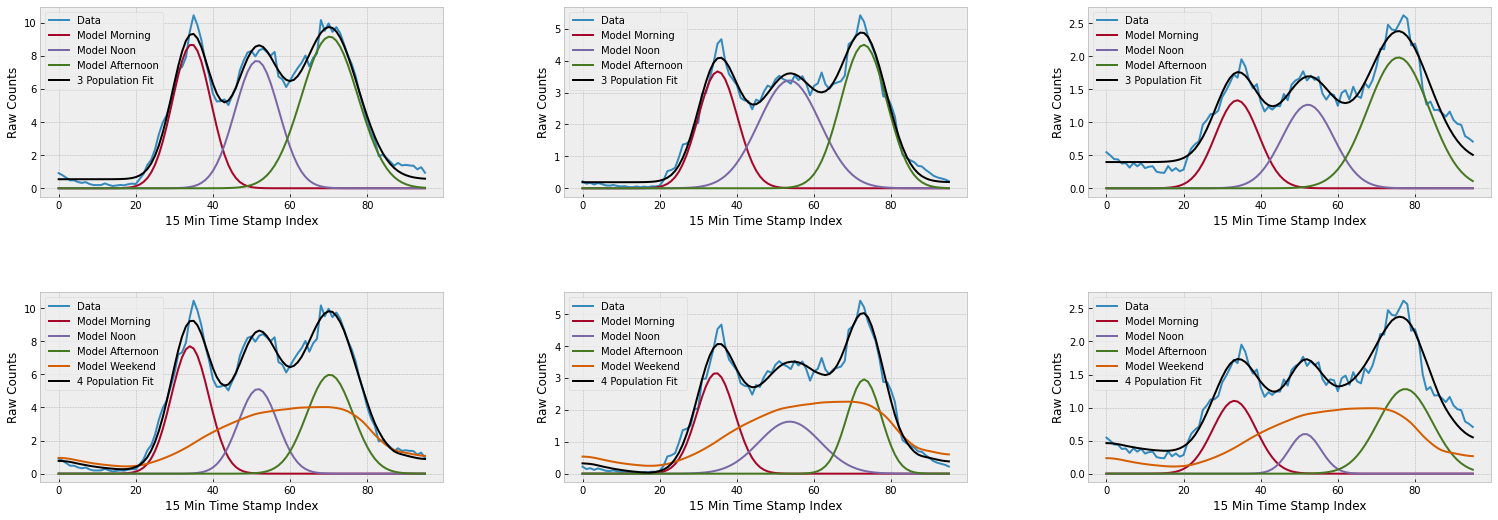

In [ ]:
plt.style.use("bmh")
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=[26, 14])
fig.subplots_adjust(hspace=0.5, wspace =0.3)

m1, m2, m3, sd1, sd2, sd3, scl1, scl2, scl3, off = plsq3[23]["x"]
model1 = gauss(xval_final, m1, sd1, scl1)
model2 = gauss(xval_final, m2, sd2, scl2)
model3 = gauss(xval_final, m3, sd3, scl3)
pdat = camarr[23]
resid = pdat - off
off = off
plt.style.use("bmh")

fig = plt.subplot(3, 3, 1)
plt.plot(xval_final, camarr[23], label="Data")

plt.plot(model1, label="Model Morning")
plt.plot(model2, label="Model Noon")
plt.plot(model3, label="Model Afternoon")
plt.plot(model1 + model2 + model3 + off, "k", 
          label="3 Population Fit")

#ax.set_title("camarr index: {0}".format(i))
plt.xlabel("15 Min Time Stamp Index")
plt.ylabel("Raw Counts")
plt.legend()


m1, m2, m3, sd1, sd2, sd3, scl1, scl2, scl3, off = plsq3[41]["x"]
model1 = gauss(xval_final, m1, sd1, scl1)
model2 = gauss(xval_final, m2, sd2, scl2)
model3 = gauss(xval_final, m3, sd3, scl3)
pdat = camarr[41]
resid = pdat - off
off = off
plt.style.use("bmh")

fig = plt.subplot(3, 3, 2)
plt.plot(xval_final, camarr[41], label="Data")

plt.plot(model1, label="Model Morning")
plt.plot(model2, label="Model Noon")
plt.plot(model3, label="Model Afternoon")
plt.plot(model1 + model2 + model3 + off, "k", 
          label="3 Population Fit")

#ax.set_title("camarr index: {0}".format(i))
plt.xlabel("15 Min Time Stamp Index")
plt.ylabel("Raw Counts")
plt.legend()

m1, m2, m3, sd1, sd2, sd3, scl1, scl2, scl3, off = plsq3[82]["x"]
model1 = gauss(xval_final, m1, sd1, scl1)
model2 = gauss(xval_final, m2, sd2, scl2)
model3 = gauss(xval_final, m3, sd3, scl3)
pdat = camarr[82]

off = off
plt.style.use("bmh")

fig = plt.subplot(3, 3, 3)
plt.plot(xval_final, camarr[82], label="Data")


plt.plot(model1, label="Model Morning")
plt.plot(model2, label="Model Noon")
plt.plot(model3, label="Model Afternoon")
plt.plot(model1 + model2 + model3 + off, "k", 
          label="3 Population Fit")

#ax.set_title("camarr index: {0}".format(i))
plt.xlabel("15 Min Time Stamp Index")
plt.ylabel("Raw Counts")
plt.legend()


m1, m2, m3, sd1, sd2, sd3, scl1, scl2, scl3, wamp, off = plsq4[23]["x"]
model1 = gauss(xval_final, m1, sd1, scl1)
model2 = gauss(xval_final, m2, sd2, scl2)
model3 = gauss(xval_final, m3, sd3, scl3)
pdat = camarr[23]
resid = pdat - wamp * wendvals - off
model4 = wamp * wendvals
model5 = camarr[23] - wamp * wendvals
off = off
plt.style.use("bmh")

fig = plt.subplot(3, 3, 4)
plt.plot(xval_final, camarr[23], label="Data")

plt.plot(model1, label="Model Morning")
plt.plot(model2, label="Model Noon")
plt.plot(model3, label="Model Afternoon")
plt.plot(uf(wamp * wendvals), label="Model Weekend")
plt.plot(model1 + model2 + model3 + wamp * wendvals + off, "k", 
          label="4 Population Fit")

#ax.set_title("camarr index: {0}".format(i))
plt.xlabel("15 Min Time Stamp Index")
plt.ylabel("Raw Counts")
plt.legend()


m1, m2, m3, sd1, sd2, sd3, scl1, scl2, scl3, wamp, off = plsq4[41]["x"]
model1 = gauss(xval_final, m1, sd1, scl1)
model2 = gauss(xval_final, m2, sd2, scl2)
model3 = gauss(xval_final, m3, sd3, scl3)
pdat = camarr[41]
resid = pdat - wamp * wendvals - off
model4 = wamp * wendvals
model5 = camarr[41] - wamp * wendvals
off = off
plt.style.use("bmh")

fig = plt.subplot(3, 3, 5)
plt.plot(xval_final, camarr[41], label="Data")


plt.plot(model1, label="Model Morning")
plt.plot(model2, label="Model Noon")
plt.plot(model3, label="Model Afternoon")
plt.plot(uf(wamp * wendvals), label="Model Weekend")
plt.plot(model1 + model2 + model3 + wamp * wendvals + off, "k", 
          label="4 Population Fit")

#ax.set_title("camarr index: {0}".format(i))
plt.xlabel("15 Min Time Stamp Index")
plt.ylabel("Raw Counts")
plt.legend()



m1, m2, m3, sd1, sd2, sd3, scl1, scl2, scl3, wamp, off = plsq4[82]["x"]
model1 = gauss(xval_final, m1, sd1, scl1)
model2 = gauss(xval_final, m2, sd2, scl2)
model3 = gauss(xval_final, m3, sd3, scl3)
pdat = camarr[82]
resid = pdat - wamp * wendvals - off
model4 = wamp * wendvals
model5 = camarr[82] - wamp * wendvals
off = off
plt.style.use("bmh")

fig = plt.subplot(3, 3, 6)
plt.plot(xval_final, camarr[82], label="Data")


plt.plot(model1, label="Model Morning")
plt.plot(model2, label="Model Noon")
plt.plot(model3, label="Model Afternoon")
plt.plot(uf(wamp * wendvals), label="Model Weekend")
plt.plot(model1 + model2 + model3 + wamp * wendvals + off, "k", 
          label="4 Population Fit")

#ax.set_title("camarr index: {0}".format(i))
plt.xlabel("15 Min Time Stamp Index")
plt.ylabel("Raw Counts")
plt.legend()


rawfile = os.path.join("drive", "My Drive", "lwir", "output","figure2", "model_comparison")
plt.savefig(rawfile)
